In [1]:
# first import data 
#sshfs ascott47@jhu.edu@gateway2.marcc.jhu.edu:/scratch/groups/bzaitch1/badr/ mountpoint/
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import matplotlib.cm as cm
import scipy.spatial
import os 
import string
import scipy.stats

home_dir = os.getenv("HOME")

#source activate python2
from netCDF4 import Dataset
from wrf import getvar
import wrf
from wrf import ALL_TIMES

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [102]:
filepath = '../cityheat/Bmore/2016/'
meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
meta = meta.set_index('sensornumber', drop = False)
meta = meta.set_index(meta.index.astype('float64'), drop = False)
#mean_temp = pd.read_csv('meantemp.csv', header=-1).rename(columns = {0: 'SensorNumber', 1:'MeanTemp'}).set_index('SensorNumber')
tempDF = pd.read_csv(filepath + 'data/CleanedTemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')#.first()
tempDF.columns = tempDF.columns.astype('int')
# remove data before the thermometer was installed
for ind in tempDF.columns : 
    start_hour = pd.to_datetime(meta.loc[ind,'time'][0:13] + ':00:00 UTC ' + meta.loc[ind,'time'][-4:])
    tempDF.loc[:start_hour,ind] = np.nan
    
start_date = '2016-07-01'
end_date = '2016-08-30'
tempDF = tempDF[start_date:end_date][meta['location:Longitude'].dropna().index].drop(41,axis=1)
meta =meta.loc[tempDF.columns]
# remember to subtract bias

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()


In [104]:
exp = 'UCM'
dom = 'd03'
fpath = home_dir + '/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
analysis_points = meta[['location:Longitude', 'location:Latitude']].dropna()
dataset_list = []
for file in files[0:24]:
    dataset_list.append(Dataset(file))

t2 = getvar(dataset_list, varname = "T2", 
              timeidx = wrf.ALL_TIMES, 
              method = 'cat'
              )
# convert to degrees C
t2 = t2 - 273.15
lc = getvar(dataset_list[-1], "LU_INDEX")
pts = wrf.ll_to_xy(dataset_list[-1],analysis_points['location:Latitude'], analysis_points['location:Longitude'])
data = t2.isel(west_east = pts.values[0], south_north = pts.values[1])

In [111]:
exp = 'UCM'
dom = 'd03'
fpath = home_dir + '/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
len(files)

196

In [112]:
dom = 'd02'
fpath = home_dir + '/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
len(files)

2353

In [58]:
lcc_english = {
    #! 40 CLASS MODIS (Outside US, cats 1-20)/NLCD (US only, cats 21-40) LU characterization
    # downloaded from https://github.com/yyr/wrf/blob/master/phys/module_sf_pxlsm_data.F March 8 2018
    1: 'Evergreen Needleleaf Forest',
    2:  'Evergreen Broadleaf Forest',
    3:  'Deciduous Needleleaf Forest',
    4:   'Deciduous Broadleaf Forest',
    5: 'Mixed Forest',
    6:  'Closed Shrublands', 
    7:'Open Shrublands', 
    8: 'Woody Savanna', 
    9:'Savanna', 
    10: 'Grasslands', 
    11: 'Perminent Wetlands', 
    12: 'Croplands',
    13: 'Urban andBuilt-up', 
    14: 'Cropland/Natural Vegetation Mosaic', 
    15: 'Snow and Ice', 
    16: 'Barren or Sparsely Vegetated', 
    17:  'IGBP water', 
    18: 'unclassified', 
    19: 'fill value (normally ocean water)', 
    20: 'unclassified', 
    21: 'Open water', 
    22: 'Perennial Ice/snow', 
    23: 'Developed, Open space', 
    24:'Developed, Low Intensity', 
    25: 'Developed, Medium Intensity', 
    26: 'Developed, High Intensity', 
    27: 'Barren land', 
    28: 'Deciduous Forest', 
    29: 'Evergreen Forest', 
    30: 'Mixed Forest',
    31: 'Dwarf Scrub', 
    32:  'Shrub/Scrub', 
    33: 'Grassland/Herbaceous', 
    34: 'Sedge/Herbaceous',
    35: 'Lichens', 
    36: 'Moss', 
    37: 'Pasture/Hay',
    38: 'Cultivated Crops',
    39: 'Woody Wetland',
    40: 'Emergent Herbaceous Wetland',
}

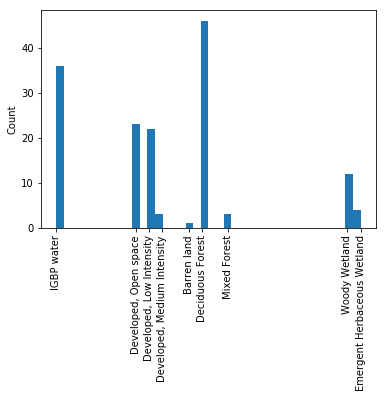

In [71]:
patches = plt.hist(np.diag(lc), bins = 40)
markers = plt.xticks(np.unique(np.diag(lc)),
                     [lcc_english[int(x)]for x in np.unique(np.diag(lc))], rotation='vertical')
plt.ylabel('Count')

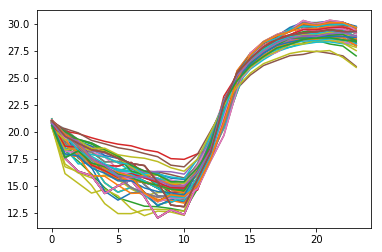

In [43]:
for i in range(len(analysis_points)):
    plt.plot(data[:,i,i])

In which run has largest UHI, we saw that the UCM 6am run has largest UHI

# Compute error statistics

RMSE, correlation, bias, hit rate, index of agreement, and coefficient of determination

In [72]:
# rmse
from sklearn.metrics import mean_squared_error
# correlation 
# hit rate 
# index of agreement
# coefficient of determination

In [108]:
# make sure it's for the same dates
# make sure that tempDF and meta are indexed in the same order
rmse = mean_squared_error(tempDF.mean(), np.diag(data.mean(axis=0)))
correlation = scipy.stats.pearsonr(tempDF.mean(), np.diag(data.mean(axis=0)))

33.561455264507536

In [ ]:
data

In [ ]:
# snap points to grid and get coordinate locations of the points
ncfile = Dataset(home_dir + 'mountpoint/d03/wrfout_d01_2016-06-01_10:00:00') # 10am UTC is 6am local
t2 = getvar(ncfile, "T2")
fig  = (t2-273.15).plot(figsize = [35,25])
ax = fig.get_axes()

analysis_points = meta[['location:Longitude', 'location:Latitude']].dropna()
unique_locations = []
for point in analysis_points.values: 
    results = tree.query(point, k = 5, distance_upper_bound=1) # lookup closest points; returns first row as distance and second row as index
    location = df.iloc[results[1][0]].name # get the 'name', or coordinate location, of the points
    if location not in unique_locations: 
        unique_locations.append(location)
    ax.scatter(location[1], location[0],  marker = '^', color = 'r')

In [ ]:
# ['SciCenter', 'Urban Forest', 'Urban Park', 'Rural', 'Inner City']
selected_pts = [] # probably: developed low intensity, developed medium intensity 

# Diurnal cycle 

In [ ]:
for i in range(len(analysis_points)):
    plt.plot(data[:,i,i])

# UHI intensity as a function of distance from the city center
# Variability within city


# Variability by landcover type


# Change during warmer periods
